### Which running backs have had 50+ carries in each of the last 5 years?

This notebook scrapes data from [Pro Football Reference](https://www.pro-football-reference.com/)'s Rushing and Receiving data table and places it into a data frame ([sample table](https://www.pro-football-reference.com/years/2017/rushing.htm)). The notebook uses the `Requests` and `Beautiful Soup 4` modules to gather the web page data. A `Player` class is used to create objects representing a single player. The program loops through the 5 most recent NFL seasons and gathers data for each season. A column for the player's fantasy points for the season is added to each data frame. The points total is based on a standard Yahoo! league (0 PPR). A data frame for each season is placed in a list, and this list is concatenated into one big data frame. Then, various manipulations are made to the data frame to find all running backs who have had 50 or more rushing attempts in each of the last 5 years. The final data frame is saved as a `.csv` file.

** Note: **This module will take a little while to run (about 30 secons on my system). It is gathering fumbles lost, reutrn yards, return touchdowns, and two point conversion data from a www.footballdb.com for each year.

 **Import the needed modules:**

In [63]:
import pandas as pd
import datetime

# Putting '..' on sys.path because Player import was causing an error when scraper.py is imported from
# another module (such as 5_seasons_50_carries.py).
import sys
import os

# os.path.split() splits the head and tail of the path for the file.
# This line of code grabs the head, joins it with '..', and inserts the path into the first element of sys.path.
sys.path.insert(0, '..')

import pro_football_ref_scraper as pfbr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def modify_data_frame(data_frame_list, num_years, player_url=False):
    """
    This function takes a list of data frames as input. It concatenates the data frames together
    to create one large data frame. It then modifies the data to get the running backs with 50 or
    more carries in each of the past num_years season. The modified data frame is returned.
    """
    # Concatenate the data frames to create one large data frame that has data for each season.
    big_df = pd.concat(data_frame_list)

    # Keep the player_url column in the data frame when player_url=True
    if not player_url:
        big_df.drop('url', axis=1, inplace=True)

    # Eliminate players with fewer than 50 rush attempts.
    big_df = big_df[big_df['rush_attempts'] >= 50]

    # Some players have a NaN value their position. Any player with 50 or more rush attempts,
    # but no position is likely a running back.
    big_df['position'] = big_df['position'].fillna('RB')

    # Some running backs have their position description in lowercase letters.
    # Use a lambda function to fix this inconsistency.
    big_df['position'] = big_df['position'].apply(lambda x: 'RB' if 'rb' in x else x)

    # Only interested in running backs
    big_df = big_df[big_df['position'] == 'RB']

    # Current index is player's name. Append year to have multi-index.
    big_df.set_index('year', append=True, inplace=True)

    # Sort the data frame by the player's name
    big_df.sort_index(level='name', inplace=True)

    # Get each player's name
    names = big_df.index.get_level_values('name').unique()

    # Loop through each player. If they don't have num_years season's worth of data, then we
    # drop them from the data set.
    for name in names:
        if len(big_df.loc[name]) != num_years:
            big_df.drop(name, level=0, inplace=True)

    return big_df

**We can now execute the functions and create the final data frame:**

In [3]:
# Get the current date to help figure out which year to start gathering data from.
now = datetime.datetime.now()

# Number of years of data.
num_years = 5

# Starting with last year since it's a full season of data.
# Regular season football ends in late December or early January, so if the current
# date is late December, and the season has already ended, then unfortunately the
# newly created season will not be included in the data set.
# Football season starts the week after Labor Day weekend. Labor Day is always on
# the first Monday of September, and the NFL regular season is 17 weeks long
# (16 games + bye week for a team). From my initial calculations, if September 1 is
# Labor Day, then the NFL regular season ends on December 28.
start_year = now.year - 1

# Get the final year to gather data from.
end_year = start_year - num_years

# First, we need to scrape the data from Pro-Football Reference.

# Holds each data frame scraped from Pro-Football Reference.
# Each data frame has data for a single season.
data_frame_list = []

fb_ref = pfbr.ProFbRefScraper()

# Iterate through each year of data and create a data frame for each one.
for year in range(start_year, end_year, -1):
    df = fb_ref.get_rushing_receiving_data(year, fantasy=True)
    data_frame_list.append(df)

# Concatenate the data frames and clean the data.
big_df = modify_data_frame(data_frame_list, num_years, False)

# Write the data frame to a csv file and save it in the current working directory.
big_df.to_csv('5_seasons_50_carries.csv')

**The dimensions of the data frame (number of rows, number of columns):**

In [4]:
big_df.shape

(65, 29)

**Number of running backs with 50 or more carriers in each of the past 5 seasons (2013-2017):**

In [5]:
len(big_df.index.get_level_values('name').unique())

13

**The name of each player with 50 or more rush attempts in each of the last 5 seasons:**

In [145]:
names = list(big_df.index.get_level_values('name').unique())

In [146]:
for name in names:
    print(name)

Alfred Morris
Chris Ivory
DeMarco Murray
Doug Martin
Eddie Lacy
Frank Gore
Giovani Bernard
Lamar Miller
Le'Veon Bell
LeGarrette Blount
LeSean McCoy
Mark Ingram
Matt Forte


**No running back has a season with fewer than 50 rush attempts:**

In [207]:
big_df['rush_attempts'].min()

69

**The best fantasy season in the data set:**

In [118]:
big_df.loc[big_df['fantasy_points'].idxmax()]

team                    DAL
age                      26
position                 RB
games_played             16
games_started            16
rush_attempts           392
rush_yards             1845
rush_td                  13
longest_run              51
yards_per_rush          4.7
yards_per_game        115.3
attempts_per_game      24.5
targets                  64
receptions               57
rec_yards               416
yards_per_rec           7.3
rec_td                    0
longest_rec              34
rec_per_game            3.6
rec_yards_per_game       26
catch_percentage       89.1
scrimmage_yards        2261
rush_rec_td              13
fumbles                   6
fumbles_lost              5
two_pt_conversions        0
return_yards              0
return_td                 0
fantasy_points        294.1
Name: (DeMarco Murray, 2014), dtype: object

**The worst fantasy season in the data set:**

In [119]:
big_df.loc[big_df['fantasy_points'].idxmin()]

team                   SEA
age                     27
position                RB
games_played             9
games_started            3
rush_attempts           69
rush_yards             179
rush_td                  0
longest_run             19
yards_per_rush         2.6
yards_per_game        19.9
attempts_per_game      7.7
targets                  6
receptions               6
rec_yards               47
yards_per_rec          7.8
rec_td                   0
longest_rec             14
rec_per_game           0.7
rec_yards_per_game     5.2
catch_percentage       100
scrimmage_yards        226
rush_rec_td              0
fumbles                  0
fumbles_lost             0
two_pt_conversions       0
return_yards             0
return_td                0
fantasy_points        22.6
Name: (Eddie Lacy, 2017), dtype: object

**The data set:**

In [8]:
big_df

team  age position  games_played  games_started  \
name              year                                                   
Alfred Morris     2013  WAS   25       RB            16             16   
                  2014  WAS   26       RB            16             16   
                  2015  WAS   27       RB            16             16   
                  2016  DAL   28       RB            14              0   
                  2017  DAL   29       RB            14              5   
Chris Ivory       2013  NYJ   25       RB            15              6   
                  2014  NYJ   26       RB            16             10   
                  2015  NYJ   27       RB            15             14   
                  2016  JAX   28       RB            11              1   
                  2017  JAX   29       RB            14              3   
DeMarco Murray    2013  DAL   25       RB            14             14   
                  2014  DAL   26       RB            16             16   
                  2015  PHI   27       RB            15              8   
                  2016  TEN   28       RB            16             16   
                  2017  TEN   29       RB            15             15   
Doug Martin       2013  TAM   24       RB             6              6   
                  2014  TAM   25       RB            11             11   
                  2015  TAM   26       RB            16             16   
                  2016  TAM   27       RB             8              8   
                  2017  TAM   28       RB            11              8   
Eddie Lacy        2013  GNB   23       RB            15             15   
                  2014  GNB   24       RB            16             16   
                  2015  GNB   25       RB            15             12   
                  2016  GNB   26       RB             5              5   
                  2017  SEA   27       RB             9              3   
Frank Gore        2013  SFO   30       RB            16             16   
                  2014  SFO   31       RB            16             16   
                  2015  IND   32       RB            16             16   
                  2016  IND   33       RB            16             16   
                  2017  IND   34       RB            16             16   
...                     ...  ...      ...           ...            ...   
Lamar Miller      2013  MIA   22       RB            16             15   
                  2014  MIA   23       RB            16             16   
                  2015  MIA   24       RB            16             16   
                  2016  HOU   25       RB            14             14   
                  2017  HOU   26       RB            16             13   
Le'Veon Bell      2013  PIT   21       RB            13             13   
                  2014  PIT   22       RB            16             16   
                  2015  PIT   23       RB             6              6   
                  2016  PIT   24       RB            12             12   
                  2017  PIT   25       RB            15             15   
LeGarrette Blount 2013  NWE   27       RB            16              7   
                  2014  2TM   28       RB            16              1   
                  2015  NWE   29       RB            12              6   
                  2016  NWE   30       RB            16              8   
                  2017  PHI   31       RB            16             11   
LeSean McCoy      2013  PHI   25       RB            16             16   
                  2014  PHI   26       RB            16             16   
                  2015  BUF   27       RB            12             12   
                  2016  BUF   28       RB            15             15   
                  2017  BUF   29       RB            16             16   
Mark Ingram       2013  NOR   24       RB            11              3   
                  2014  NOR

**Reset the index so we can use the 'name' column for plotting data:**

In [23]:
df_no_index = big_df.reset_index()

**Display each player's past 5 fantasy seasons in a line plot:**

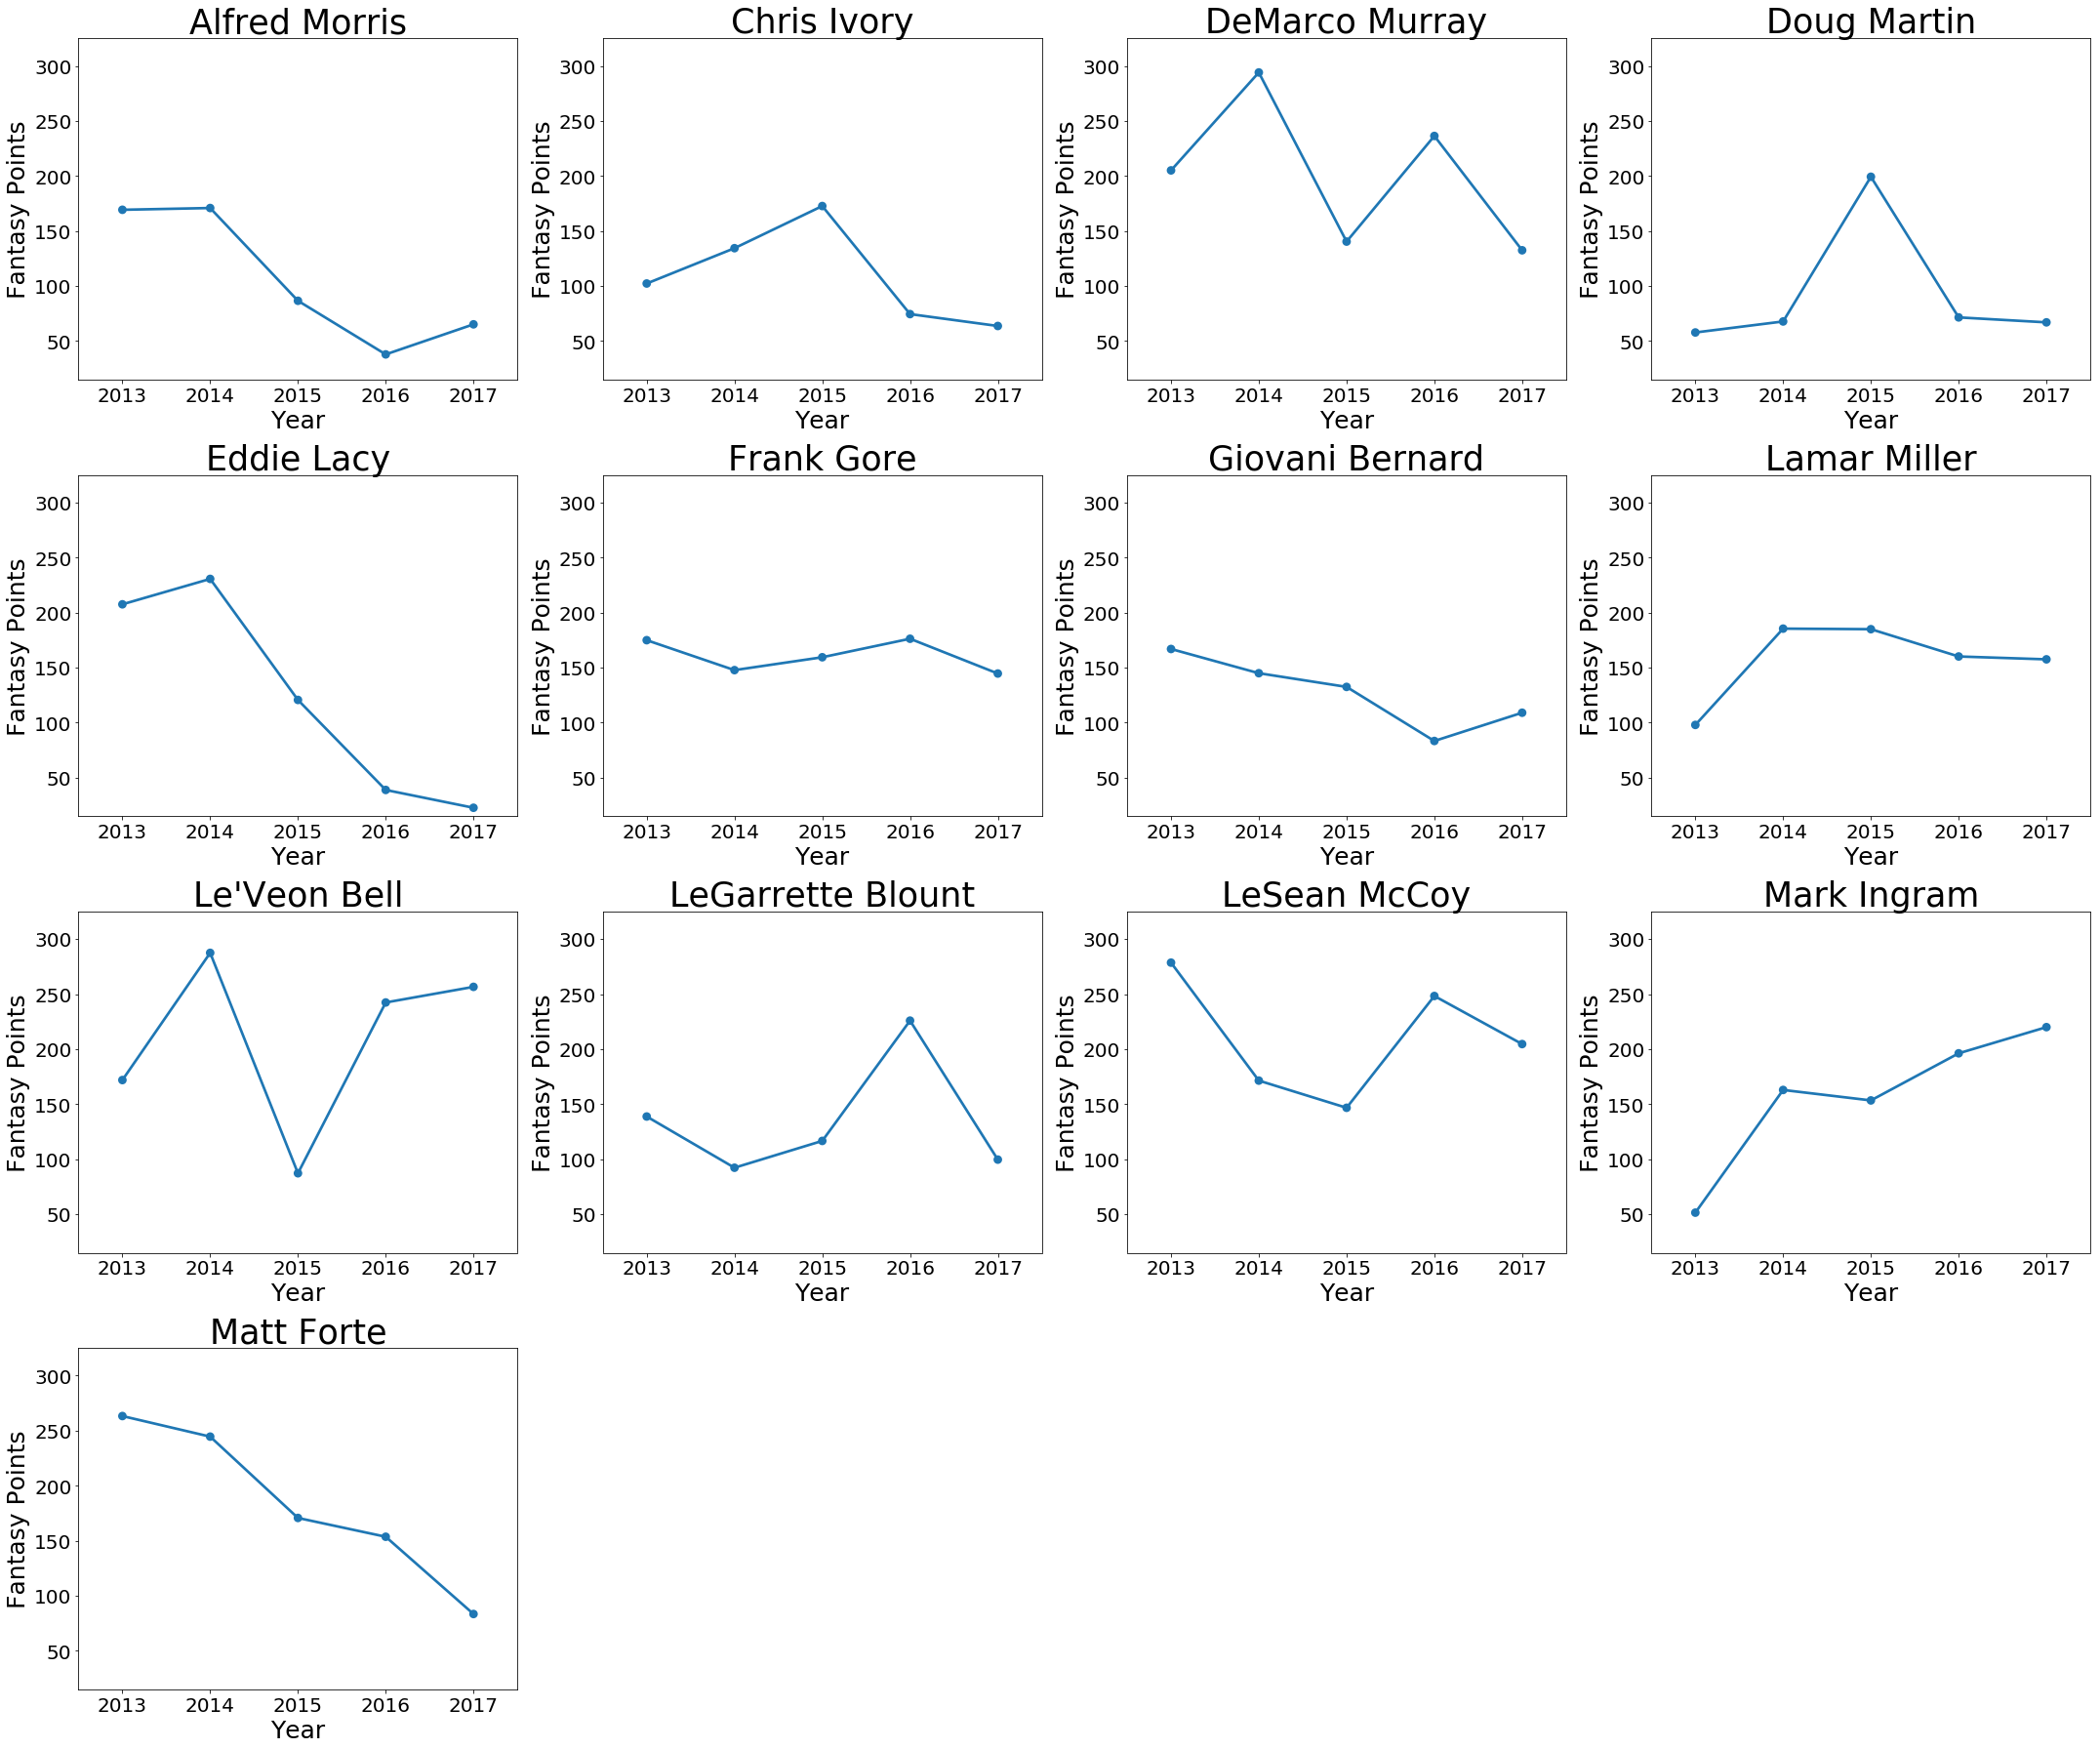

In [205]:
fig = plt.figure(figsize=(30, 25))

for i, name in enumerate(names, 1):
    ax = fig.add_subplot(4, 4, i)
    sns.pointplot(x='year', y='fantasy_points', data=df_no_index[df_no_index['name'] == name], ci=0)
    ax.set_ylim([15,325])
    ax.set_title(name, size=35)
    ax.set_ylabel('Fantasy Points', size=25)
    ax.set_xlabel('Year', size=25)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()

**Display each player's total rush attempts (carries) over the past 5 seasons:**

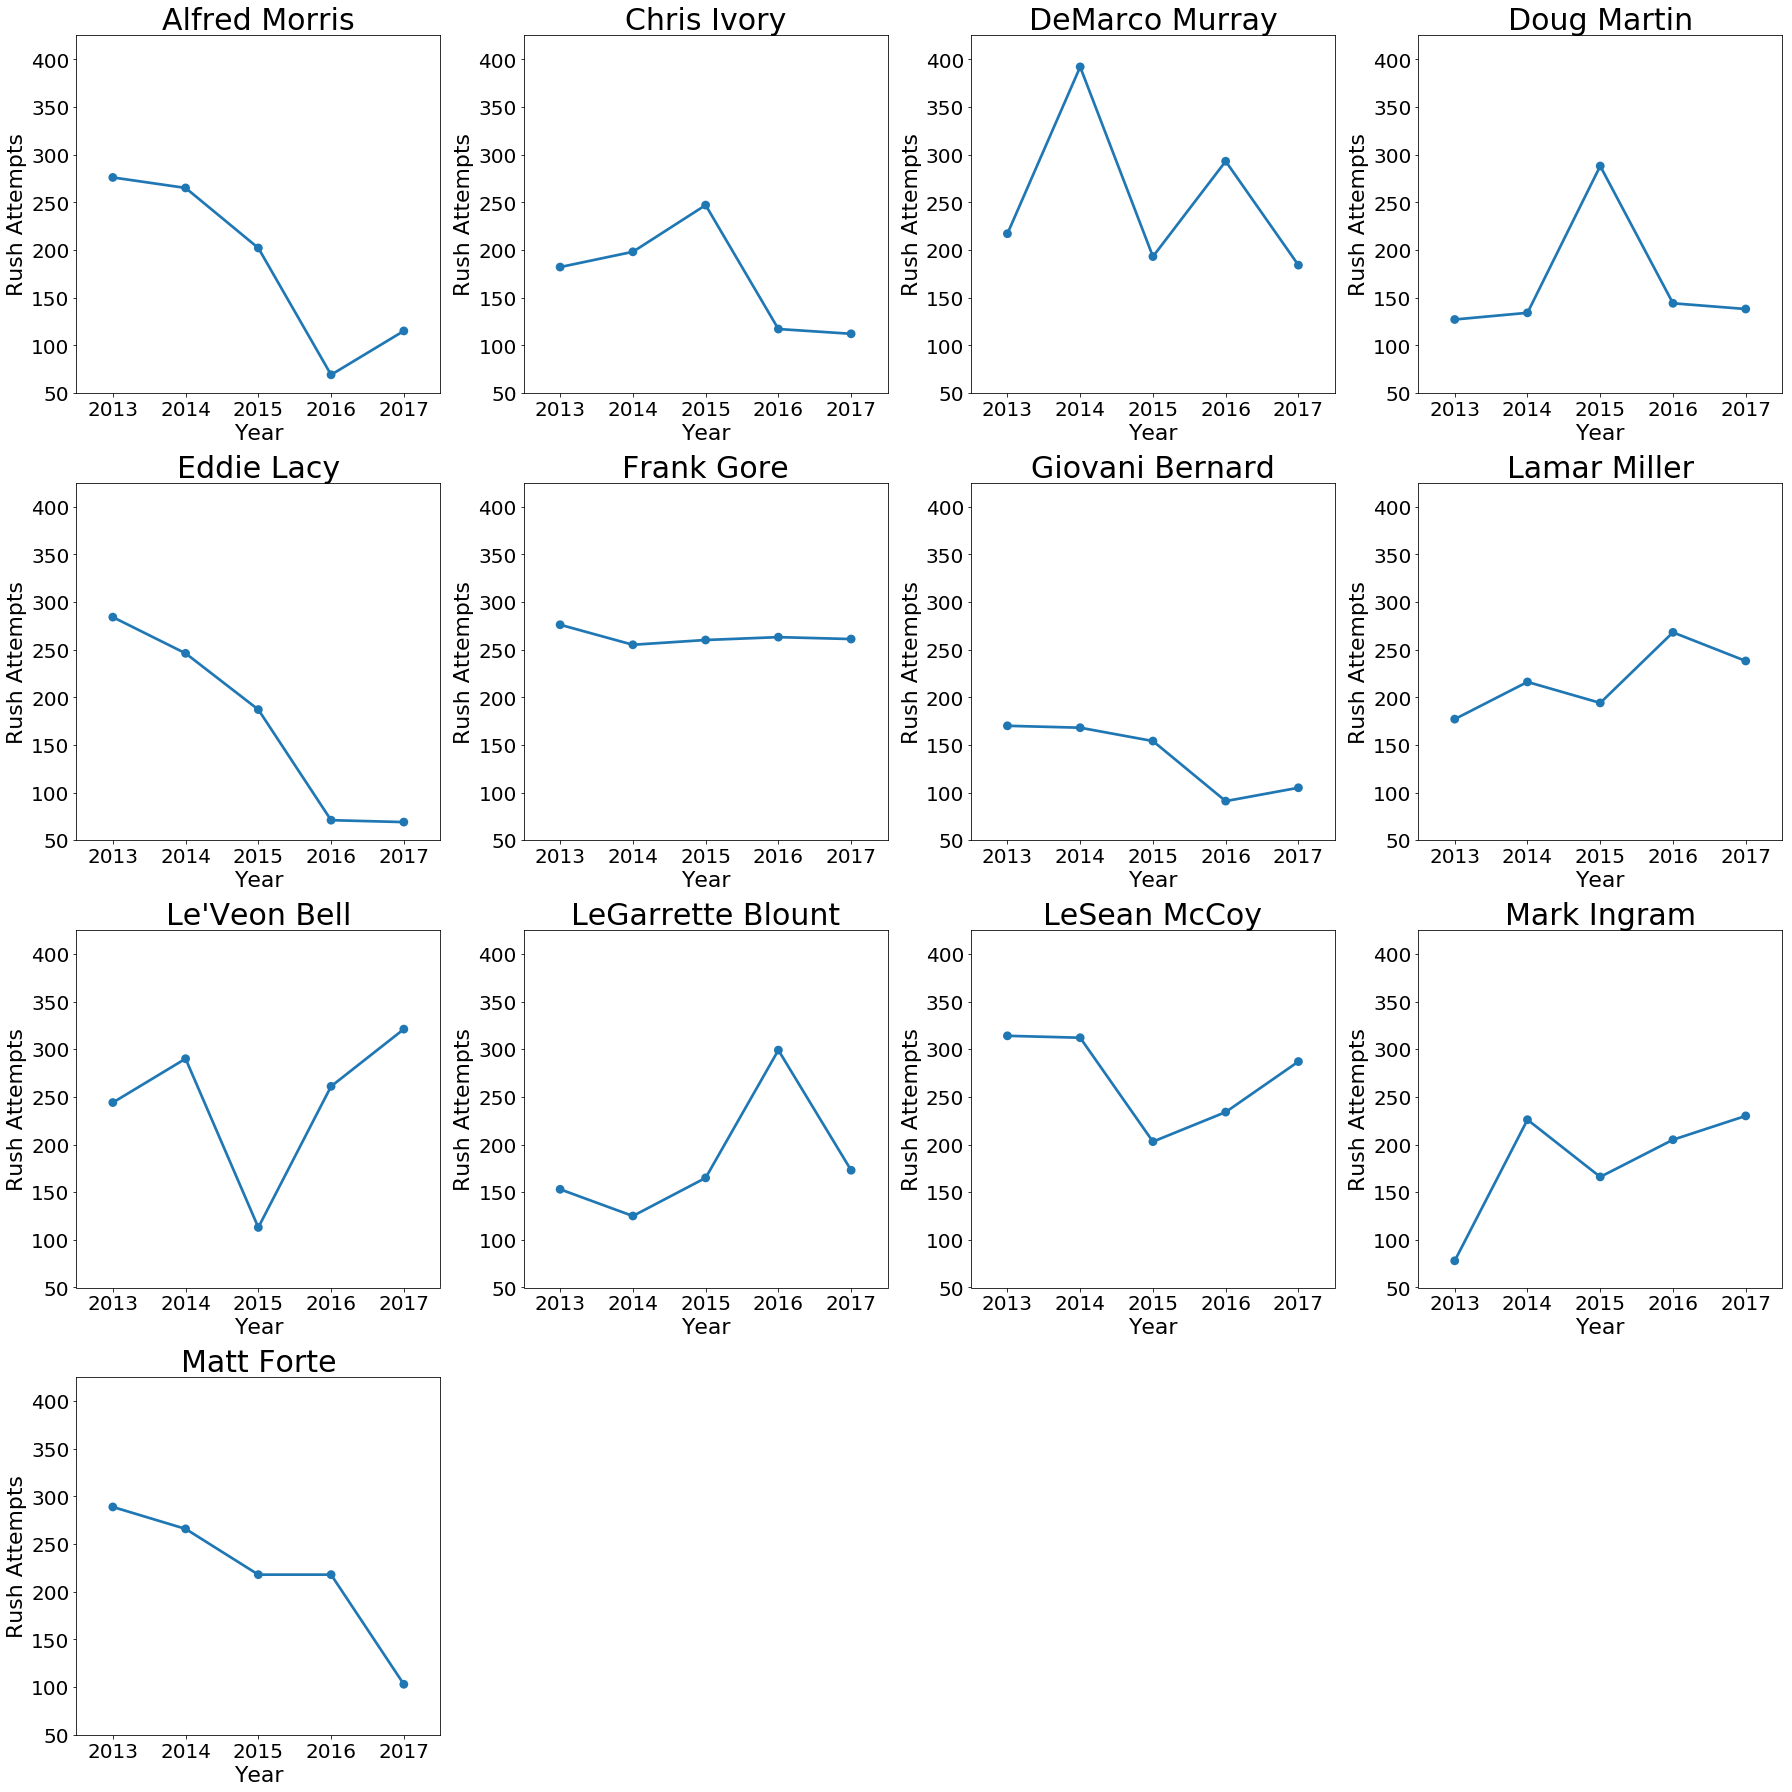

In [206]:
fig = plt.figure(figsize=(25, 25))

for i, name in enumerate(names, 1):
    ax = fig.add_subplot(4, 4, i)
    sns.pointplot(x='year', y='rush_attempts', data=df_no_index[df_no_index['name'] == name], ci=0)
    ax.set_ylim([50, 425])
    ax.set_title(name, size=30)
    ax.set_ylabel('Rush Attempts', size=22)
    ax.set_xlabel('Year', size=22)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()

**Display the number of games each player played in during the past 5 seasons:**

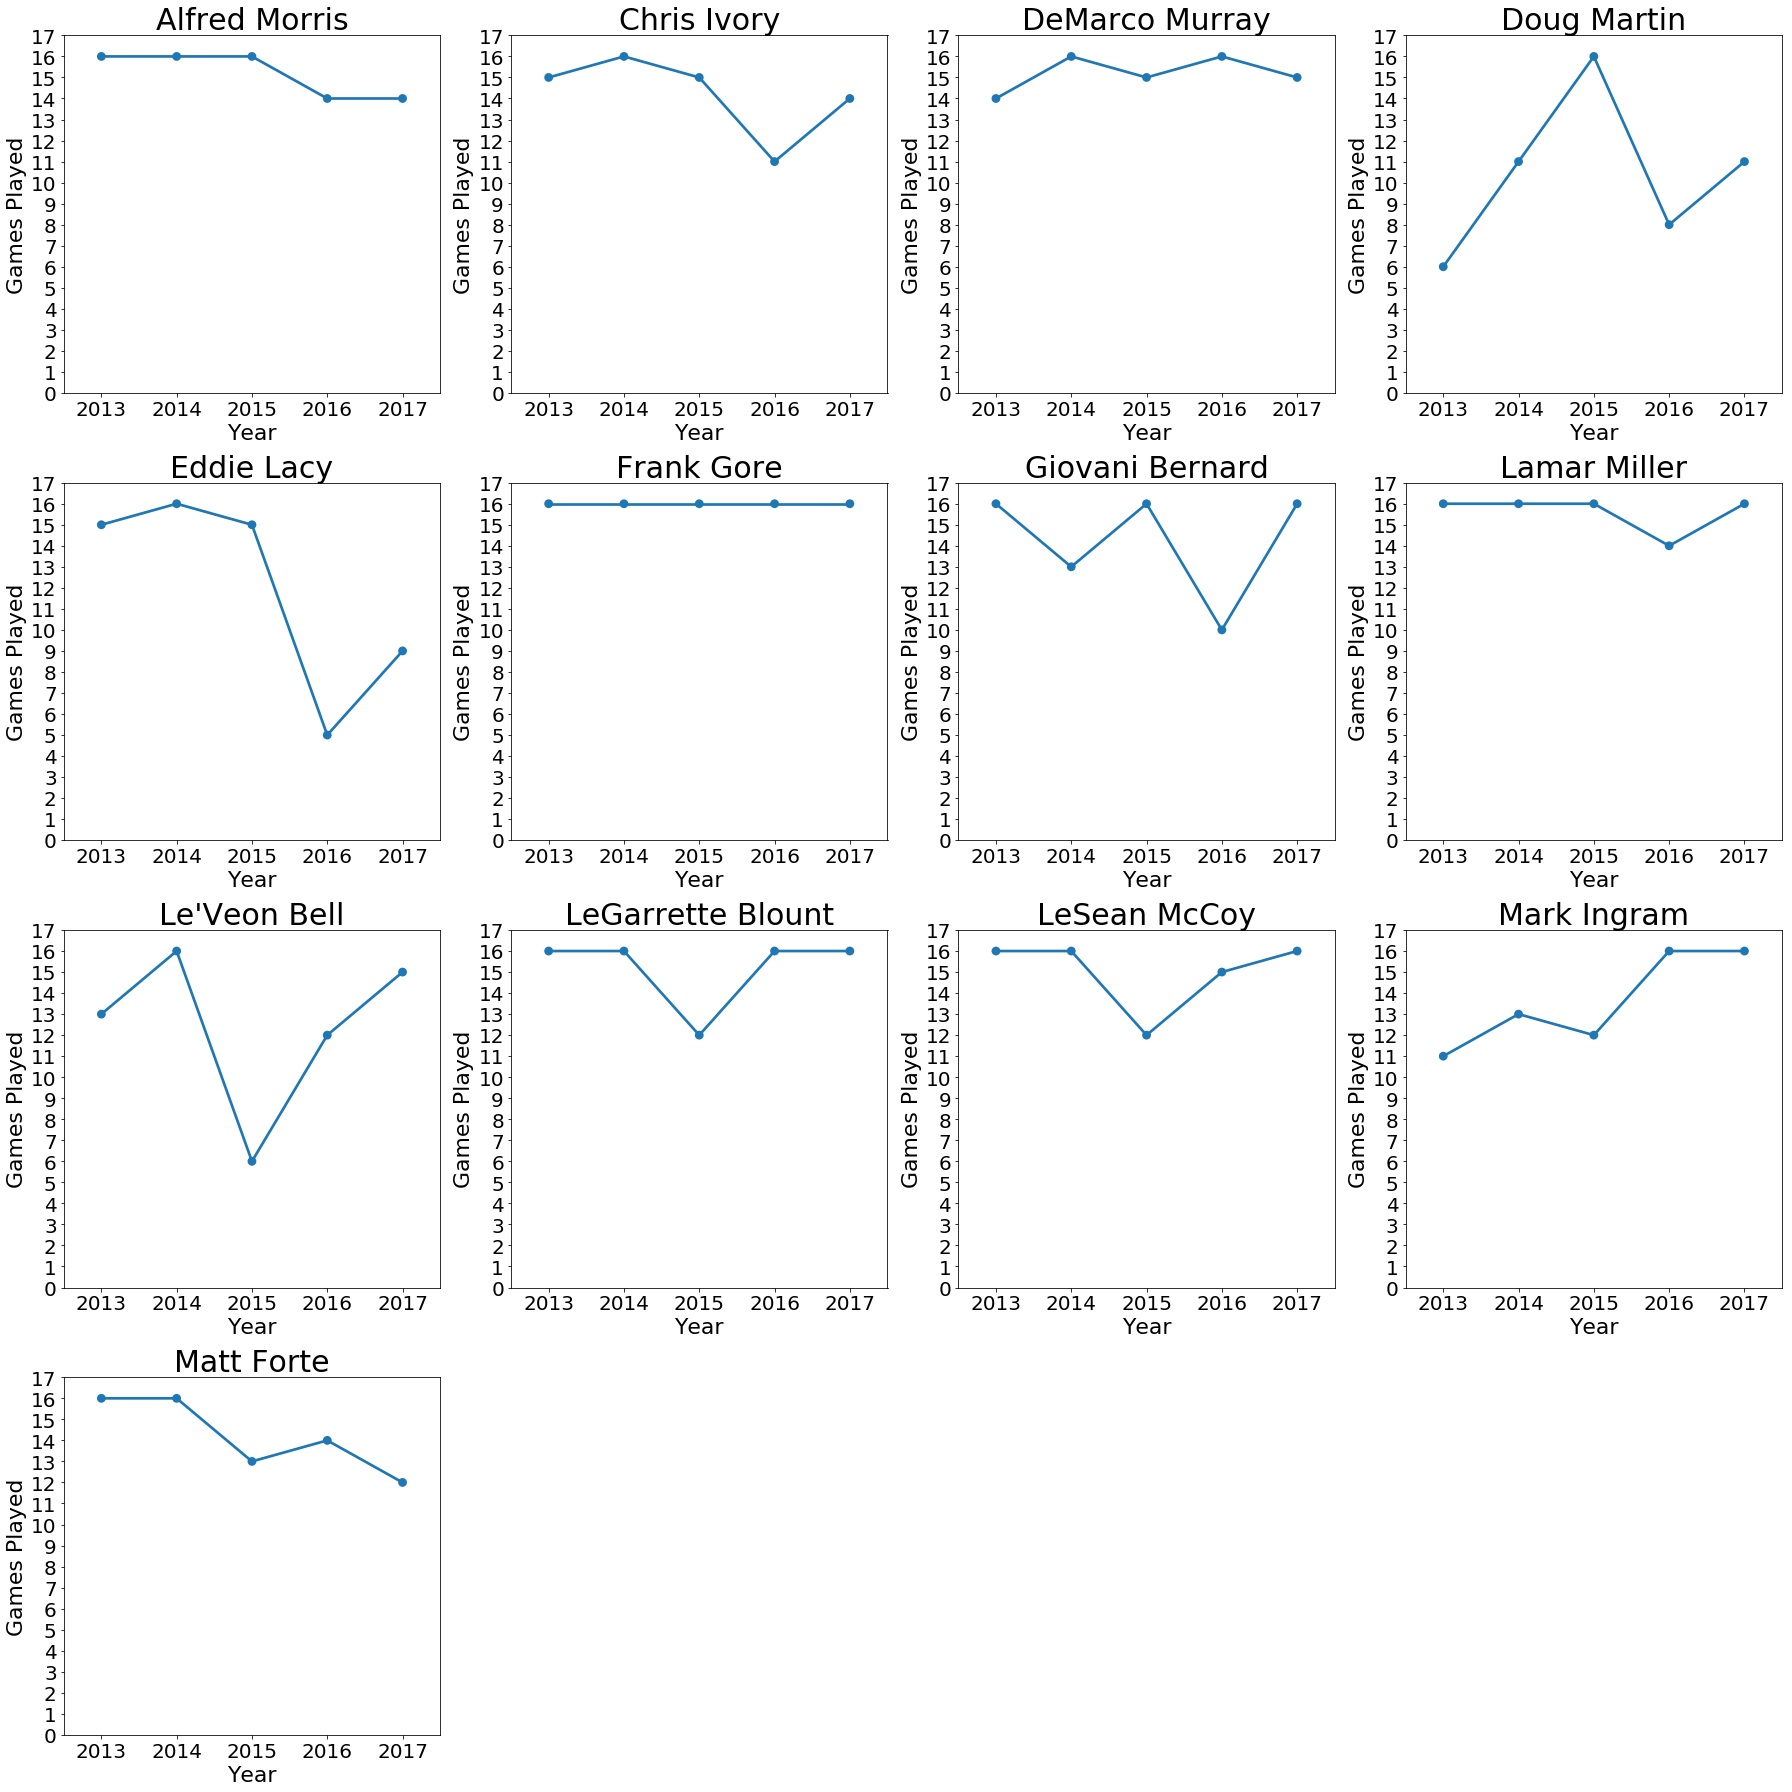

In [201]:
fig = plt.figure(figsize=(25, 25))

for i, name in enumerate(names, 1):
    ax = fig.add_subplot(4, 4, i)
    sns.pointplot(x='year', y='games_played', data=df_no_index[df_no_index['name'] == name], ci=0)
    ax.set_ylim([0,17])
    ax.set_title(name, size=30)
    ax.set_ylabel('Games Played', size=22)
    ax.set_xlabel('Year', size=22)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.yaxis.set_major_locator(plt.MaxNLocator(17))

plt.tight_layout()

**As expected, rush attempts (carries) and fantasy points are highly correlated:**

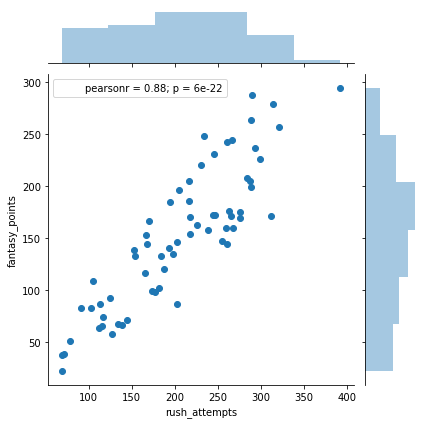

In [148]:
sns.jointplot(x='rush_attempts', y='fantasy_points', data=df_no_index, kind='scatter')

**How each statistic is correlated:**

In [153]:
# Dropping return_td column because no player in the data set has a return touchdown in any of the past 5 seasons.
big_df_corr = big_df.drop('return_td', axis=1).corr()

In [158]:
big_df_corr

,age,games_played,games_started,rush_attempts,rush_yards,rush_td,longest_run,yards_per_rush,yards_per_game,attempts_per_game,...,rec_per_game,rec_yards_per_game,catch_percentage,scrimmage_yards,rush_rec_td,fumbles,fumbles_lost,two_pt_conversions,return_yards,fantasy_points
age,1.000000,0.164554,0.077551,0.046576,-0.047639,-0.048940,-0.223335,-0.252779,-0.184680,-0.093732,...,-0.240760,-0.250809,0.046007,-0.117786,-0.019875,0.105173,0.079879,0.162691,0.015333,-0.091160
games_played,0.164554,1.000000,0.483256,0.601931,0.594022,0.451854,0.347328,0.219211,0.104971,0.027844,...,0.042158,0.090402,0.067023,0.560372,0.519782,0.322117,0.303789,0.023228,0.076506,0.574477
games_started,0.077551,0.483256,1.000000,0.820766,0.781298,0.494558,0.384130,0.195119,0.649731,0.668697,...,0.283623,0.252509,0.143281,0.716932,0.557998,0.383396,0.363970,0.169657,-0.157717,0.690874
rush_attempts,0.046576,0.601931,0.820766,1.000000,0.952199,0.715611,0.269986,0.222553,0.776761,0.799074,...,0.367461,0.354148,0.186570,0.890682,0.753946,0.565963,0.473155,0.073998,-0.135654,0.879116
rush_yards,-0.047639,0.594022,0.781298,0.952199,1.000000,0.745411,0.401011,0.483481,0.845972,0.748233,...,0.395948,0.382689,0.196800,0.936342,0.781876,0.587928,0.491418,0.122200,-0.079900,0.923619
rush_td,-0.048940,0.451854,0.494558,0.715611,0.745411,1.000000,0.371206,0.344057,0.616509,0.554934,...,0.308523,0.279901,0.242492,0.693744,0.949276,0.434991,0.355256,0.044747,0.028628,0.816466
longest_run,-0.223335,0.347328,0.384130,0.269986,0.401011,0.371206,1.000000,0.505413,0.287609,0.098817,...,0.083564,0.057162,0.083340,0.347245,0.357796,0.103738,0.213441,0.101256,-0.015305,0.366414
yards_per_rush,-0.252779,0.219211,0.195119,0.222553,0.483481,0.344057,0.505413,1.000000,0.516847,0.146672,...,0.198804,0.180190,0.021097,0.443859,0.355255,0.245360,0.149331,0.157884,0.161156,0.444278
yards_per_game,-0.184680,0.104971,0.649731,0.776761,0.845972,0.616509,0.287609,0.516847,1.000000,0.913609,...,0.474806,0.414399,0.174748,0.789060,0.623524,0.495807,0.374055,0.142581,-0.118008,0.766071
attempts_per_game,-0.093732,0.027844,0.668697,0.799074,0.748233,0.554934,0.098817,0.146672,0.913609,1.000000,...,0.436751,0.376022,0.155416,0.695790,0.556307,0.459829,0.350892,0.084779,-0.182781,0.673516


**Heatmap displaying the correlations:**

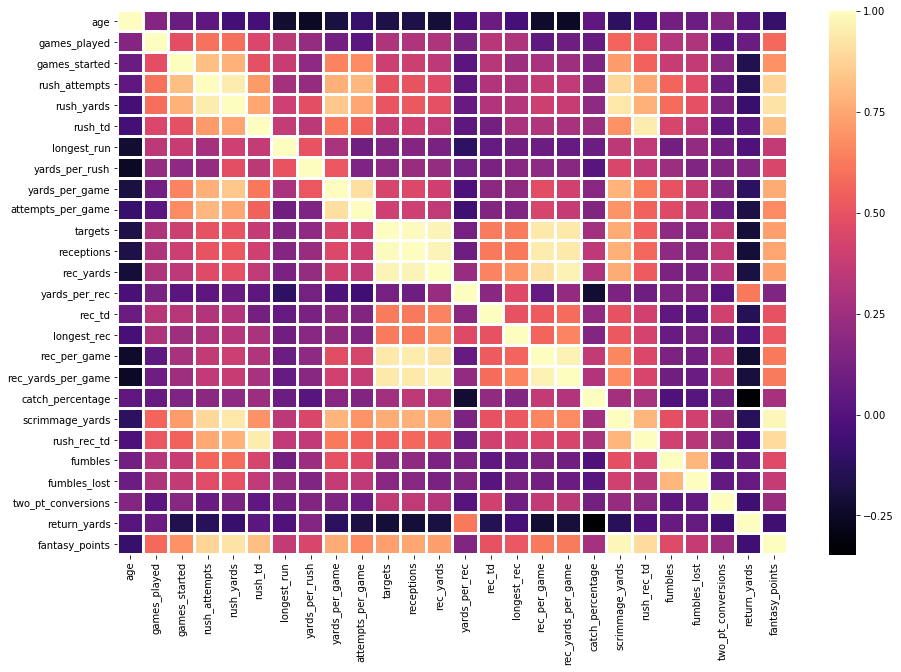

In [161]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(big_df_corr, cmap='magma', linecolor='white', linewidth=2)

It appears that age has a low/negative correlation with all other statistics. This makes sense because runningbacks tend to not "age well" in the NFL. The age of 30 is considered to be when there is a drop off in a running back's abilities. Whether it's because of a drop in durability, production, or an attempt to preserve health, older running back's tend to have a lower carry count. This causes a drop in all statistical areas.

There is also a low/negative correlation between return yards and most other statistical categories. Punt and kick returns are considered to be the most dangerous plays in football. This leads to a higher probability of injury for the returner. A good running back is likely to have good rushing (and maybe even receiving) statistics. The better they are in those areas, the less likely they are to be used to return punts or kickoffs (unless they are really good at it).

The field with the most consistently high correlation is fantasy points. This should be no suprise because the more a player excels on the field, the high fantasy production they will have. However, there are some exceptions with some fields in the data. The major ones include age and return yards, as explained above.

**Get data for the 2017 only:**

In [166]:
big_df_2017 = big_df.iloc[big_df.index.get_level_values('year') == 2017]

**Sort by age:**

In [174]:
big_df_2017.sort_values(by='age', axis=0, ascending=False)

,,team,age,position,games_played,games_started,rush_attempts,rush_yards,rush_td,longest_run,yards_per_rush,...,rec_yards_per_game,catch_percentage,scrimmage_yards,rush_rec_td,fumbles,fumbles_lost,two_pt_conversions,return_yards,return_td,fantasy_points
name,year,,,,,,,,,,,,,,,,,,,,,
Frank Gore,2017,IND,34,RB,16,16,261,961,3,21,3.7,...,15.3,76.3,1206,4,3,0.0,0.0,0.0,0.0,144.60
Matt Forte,2017,NYJ,32,RB,12,4,103,381,2,20,3.7,...,24.4,82.2,674,3,1,1.0,0.0,0.0,0.0,83.40
LeGarrette Blount,2017,PHI,31,RB,16,11,173,766,2,68,4.4,...,3.1,100.0,816,3,1,1.0,1.0,0.0,0.0,99.60
Alfred Morris,2017,DAL,29,RB,14,5,115,547,1,70,4.8,...,3.2,77.8,592,1,0,0.0,0.0,0.0,0.0,65.20
Chris Ivory,2017,JAX,29,RB,14,3,112,382,1,34,3.4,...,12.5,75.0,557,2,2,2.0,0.0,0.0,0.0,63.70
DeMarco Murray,2017,TEN,29,RB,15,15,184,659,6,75,3.6,...,17.7,83.0,925,7,1,1.0,0.0,0.0,0.0,132.50
LeSean McCoy,2017,BUF,29,RB,16,16,287,1138,6,48,4.0,...,28.0,76.6,1586,8,3,1.0,0.0,0.0,0.0,204.60
Doug Martin,2017,TAM,28,RB,11,8,138,406,3,27,2.9,...,7.6,50.0,490,3,1,1.0,1.0,0.0,0.0,67.00
Mark Ingram,2017,NOR,28,RB,16,13,230,1124,12,72,4.9,...,26.0,81.7,1540,12,3,3.0,0.0,0.0,0.0,220.00


** Based on this data, which of these running backs will have the best fantasy season next year? (written on 6/21/2018) **

It's hard to be certain, but out of these players, it will likely be Le'Veon Bell. He will be 26 years old during the 2018 season, which is still a good age for running backs. It's a good mix of veteran experience and youth. If you look at Mark Ingram's fantasy points graph, you can see he has been trending up over the years. However, he will not be guaranteed to have an elite season next year because he will be splitting his workload with second year player Alvin Kamara (2017 Offensive Rookie of the Year). Frank Gore has been the most consistent and has not missed a game in the past 5 years, but he is old for a running back. He has also switched teams (now Miami Dolphins), so it is likely he will not be the main running back in his new offense. Lamar Miller is still relatively young, so he could be destined for a bounce back year. Giovani Bernard is also relatively young, but he generally does not have high workload. Eddie Lacy has been trending down since 2014 and Doung Martin has a history of being injured (as shown by his Games Played graph). Lesean McCoy is still solid, but he's getting up there in the age category. He will likely have a good fantasy season next year, but it's not certain. The remaining running backs are on the old side, and have seen reduced rush attempts in comparison to their younger years.

It will be fun to see how valid the above paragraph is after the 2018 NFL Season has ended.

** Is this data set good for predicting who the best fantasy running backs will be in 2018? **

Not necessarily, however I do expect Le'Veon Bell, Mark Ingram, Lamar Miller, and Lesean McCoy to all have at least decent 2018 fantasy seasons (barring injury). Originally, I wanted to get an idea of who the most consistent running back has been over the past 5 years. However, I believe 5 years is a long time for running backs. DeMarco Murray had the best season in this entire data set, but his fantasy output is much different now. Young players thrive in the running back position, which means you're unlikely to find a young running back with 50 or more carries in each of the last 5 seasons because they haven't even been in the league for that long. Trying to find out who will have the best fantasy season next year using a data set that includes young players will be something for another project I hope to do in the future!